In [153]:
!pip install textstat
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from textstat import flesch_kincaid_grade
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from IPython.display import display, HTML
from nltk.corpus import stopwords
import string
import pickle
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**FUNCTIONS FOR THE APPLICATION**

In [151]:
def FeatureEngg(X_Data):
  sia = SentimentIntensityAnalyzer()
  X_Data['pos_tags'] = X_Data['text'].apply(lambda x: pos_tag(word_tokenize(x)))
  X_Data['compound'] = X_Data['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
  X_Data['negative_emotional_expressions'] = X_Data['text'].apply(lambda x: x.count('hate') + x.count('fuck'))
  X_Data['sentiment'] = X_Data['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
  X_Data['exclamation_mark_count'] = X_Data['text'].apply(lambda x: x.count('!'))
  X_Data['readability_scores'] = X_Data['text'].apply(flesch_kincaid_grade)
  X_Data['uppercase_word_count'] = X_Data['text'].apply(lambda x: len([word for word in str(x).split() if word.isupper()]))
  X_Data['stopword_count'] = X_Data['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stop_words]))
  X_Data['punctuation_count'] = X_Data['text'].apply(lambda x: len([char for char in str(x) if char in string.punctuation]))
  return X_Data

def Gen_and_Stack_CSR(X_Data):
  scaler = MinMaxScaler()
  train_uwc = X_Data['uppercase_word_count'].values.reshape(-1, 1)
  train_uwc = scaler.fit_transform(train_uwc)
  train_uwc_matrix = csr_matrix(train_uwc)

  train_EMC = X_Data['exclamation_mark_count'].values.reshape(-1, 1)
  train_EMC = scaler.fit_transform(train_EMC)
  train_EMC_matrix = csr_matrix(train_EMC)

  train_stop = X_Data['stopword_count'].values.reshape(-1, 1)
  train_stop = scaler.fit_transform(train_stop)
  train_stop_matrix = csr_matrix(train_stop)

  train_nee = X_Data['negative_emotional_expressions'].values.reshape(-1, 1)
  train_nee = scaler.fit_transform(train_nee)
  train_nee_matrix = csr_matrix(train_nee)

  train_red = X_Data['readability_scores'].values.reshape(-1, 1)
  train_red = scaler.fit_transform(train_red)
  train_red_matrix = csr_matrix(train_red)

  train_sentiment = X_Data['sentiment'].values.reshape(-1, 1)
  train_sentiment = scaler.fit_transform(train_sentiment)
  train_sentiment_matrix = csr_matrix(train_sentiment)

  train_punc = X_Data['punctuation_count'].values.reshape(-1, 1)
  train_punc = scaler.fit_transform(train_punc)
  train_punc_matrix = csr_matrix(train_punc)

  train_comp = X_Data['compound'].values.reshape(-1, 1)
  train_comp = scaler.fit_transform(train_comp)
  train_comp_matrix = csr_matrix(train_comp)

  vectorizer = pickle.load(open("vectorizer.pickle", "rb"))
  X_train_tfidf = vectorizer.transform(X_Data['text'])

  X_train_features = hstack([X_train_tfidf, train_sentiment_matrix, train_EMC_matrix, train_uwc_matrix,
                           train_red_matrix, train_punc_matrix, train_stop_matrix, train_comp_matrix,
                           train_comp_matrix])
  return X_train_features

def Predict(X_train_features):
  filename = 'finalized_model.sav'
  loaded_model = pickle.load(open(filename, 'rb'))
  result = loaded_model.predict(X_train_features)
  result2 = loaded_model.predict_proba(X_train_features)
  return(result, result2)

def AppendOutput(result, proba, df):
  str_list=[]
  for i in range(0, df.shape[0]):
    str_list.append('{"model_output":"%s","confidence_score":%.2f}' % (result[i], max(proba[i]) * 100))
  df['model_output'] = str_list
  return df

def GeneratePlot(expected, predicted):
  loaded_model = pickle.load(open('finalized_model.sav', 'rb'))
  cm = confusion_matrix(expected, result)
  plt.figure(figsize=(7, 5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=loaded_model.classes_, yticklabels=loaded_model.classes_)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

def Analyze_and_Append_result(csv):
  df = pd.read_csv(csv)
  X_Data2 = FeatureEngg(df)
  X_Features = Gen_and_Stack_CSR(X_Data2)
  result, proba = Predict(X_Features)
  accuracy = accuracy_score(df['expected_sentiment'], result)
  report = classification_report(df['expected_sentiment'], result)
  print(f"Accuracy: {accuracy}")
  print("\nClassification Report:\n", report)
  GeneratePlot(df['expected_sentiment'], result)
  df2 = AppendOutput(result, proba, df)
  df2.to_csv('Appended_with_Output')
  print("CSV File Generated See the directory for now")

**EXAMPLE OUTPUT**

Accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.81      0.75        43
     neutral       0.86      0.77      0.81        48
    positive       0.84      0.81      0.83        59

    accuracy                           0.80       150
   macro avg       0.80      0.80      0.80       150
weighted avg       0.81      0.80      0.80       150



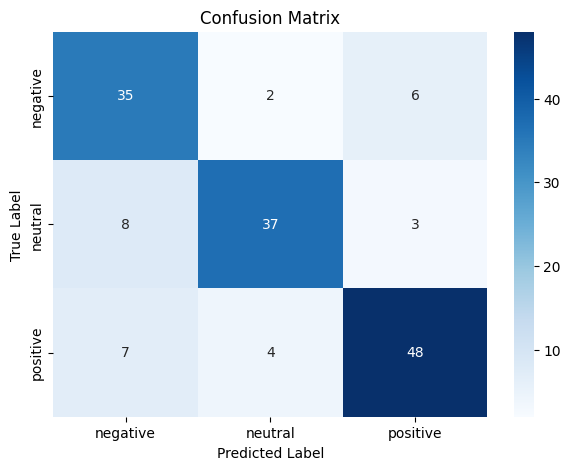

CSV File Generated See the directory for now


In [152]:
Analyze_and_Append_result('test_sentiment.csv')